## Load in choice data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data=np.load('data_hard_V1_V2.npy')

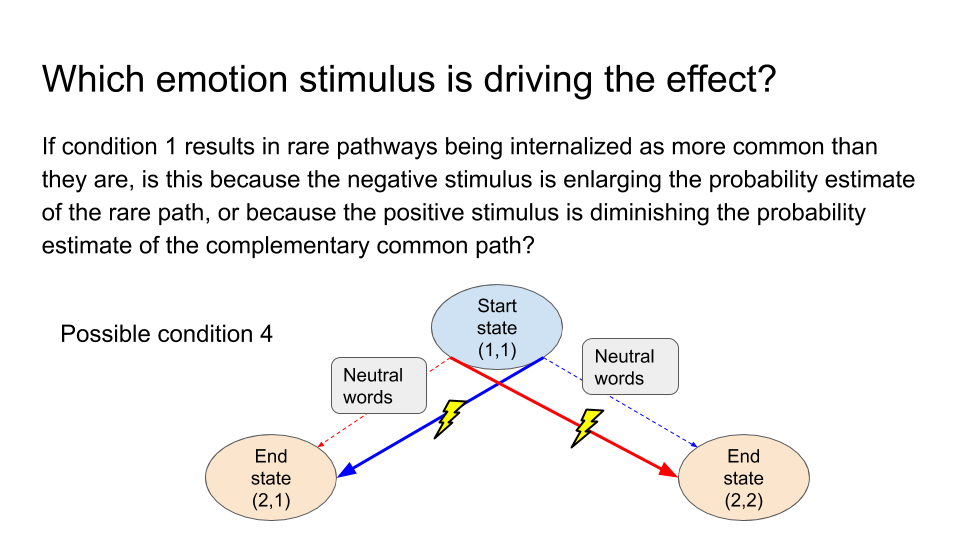

In [12]:
from IPython.display import Image
Image(filename='emotion_r2.png')

##  Modelling pilot data hierarchically: explaining choice data

In the present experiment, participants chose an action to obtain a reward based off a latent transition matrix they've presumably learned in a learning phase, and then must apply that knowledge to a test phase Above you'll see a picture of a condition in which personally-salient words interposed between the state transitions the agent is trying to learn. The hypothesis is that this transition matrix is altered due to experimentally-manipulated features (valence of emotional distractors during learning) and person-specific factors that are not manipulated (level of chronic worry). 

We can conceive of the generative model of my data in the following way as a Bayesian variant of a within-subjects ANOVA. We'll start from the bottom up. Each individual's decision is either a 1 or 0 (did they select the best-available option or not). The best-available option is the action that maximizes the EV according to a greedy policy (which is normative here given that learning has terminated once decision-making begins; that is, if I've learned I have a 60% chance pressing X will get me to the highest reward, and Y will get me there 40% of the time, I should always choose X). 

The $\theta$ parameter determines a subjects' choice, which can be thought of as their decision bias. If their decision bias is 0, it is an index that they're always choosing the worst action. If the bias is 1, they're maximizing performance. 

We use a Bernoulli likelihood to define the **subject-specific** data-generating process to explain their choice data:

$Choice_{i,k,t}$ $\sim$ Bernoulli$(\theta_{i,k})$ Indices: i=subjects, t=trials, k=condition, where k(1) = neutral, k(2) = positive and k(3) = negative. 

These decicision biases, $\theta$, are determied via a joint function of the average bias in the population, $\alpha_0$, a subject-specific factor $\eta_i$, and an experimentally-induced effect, $\gamma_k$. A logistic link function is necessary to take a parameter setting spanning all values to the 0 to 1 range in order to be used to jointly define the mean and variance of the Bernoulli likelihood.

$\theta_{i,k}\,= \begin{cases}
    \text{logistic}\, (\alpha_0 + \eta_{i} + \gamma_{1}),& \text{if } k=1\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{2}),& \text{if } k=2\\
    \text{logistic}\,(\alpha_0 + \eta_{i} + \gamma_{3}),& \text{if } k=3\\
\end{cases}
$

$\gamma_{1}$, $\gamma_{2}$, and $\gamma_{3}$ represent the biases for **each condition** modelled as a fixed effect, where each is drawn from **group-level distribution over condition effects**:

$\gamma_{k}$ $\sim \mathcal{N}(0, \sigma_{experimental})$

We also have a **subject-specific bias** drawn from the population distribution over biases. One can think of this as the tendency to learn well the state transitions in the present task necessary for good performance, marginalized over experimental effects.

$\eta_i$ $\sim$ $\mathcal{N}(0,\sigma_{subject})$

To estimate the group-level standard deviation, we used a uniform distribution ranging from 0 to 15. This allows for greater regularization of parameters. Post-estimation, we also converted parameters to reflect deflections from the grand mean, meeting the sum-to-zero constraint for more interpretability.

The posterior joint distribution one is trying to estimate is: $p(\alpha_0,\eta_i,\gamma_k|data)$. Thus we must estimate $(\text{Baseline}+i+k)$ parameters, which for the present dataset, is a 17-dimensional joint distribution. Below, I use pyStan to fit the model to the data below.

We originally included an interaction term, adding many parameters to estimate, but becaues it barely accounted for any variance & increased model complexity, we removed them from models and plots. Similarly, we also fit a random-effects model for each experimental effect, but failed to converge.

## Build hierarchical model in pyStan

In [6]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  //Group level Prior variance
  real<lower=0.01> sigma_subject;
  real<lower=0.01> sigma_condition;
  
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_ct;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;
vector[NxSubjects] theta_hrt;
vector[NxSubjects] theta_qrt;
vector[NxSubjects] theta_qn;
vector[NxSubjects] theta_fif;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          m[u,b] = a0+aW[u]+aS[b];
      }
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}



for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0+aW[1]+aS[k]);
        theta_cp[k] = inv_logit(a0+aW[2]+aS[k]);
        theta_ct[k] = inv_logit(a0+aW[3]+aS[k]);
        theta_rp[k] = inv_logit(a0+aW[4]+aS[k]);
        theta_rt[k] = inv_logit(a0+aW[5]+aS[k]);
        theta_hrt[k] = inv_logit(a0+aW[6]+aS[k]);
        theta_qrt[k] = inv_logit(a0+aW[7]+aS[k]);
        theta_qn[k] = inv_logit(a0+aW[8]+aS[k]);
        theta_fif[k] = inv_logit(a0+aW[9]+aS[k]);
        
        
    }
}
model {

    sigma_subject ~ uniform(0.01,10);
    sigma_condition ~ uniform(0.01,10);
    
    
    a0 ~ normal(0,10);
    aS ~ normal(0,sigma_subject);
    aW ~ normal(0,sigma_condition);
    
    
    for (k in 1:NxSubjects){
                
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
            
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);
            
            // Threat-rare HALF choices
            Choice[k,6,:] ~ bernoulli(theta_hrt[k]);
            
            // Threat-rare QRTR choices
            Choice[k,7,:] ~ bernoulli(theta_qrt[k]);
            
            // Neutral QRTR choices
            Choice[k,8,:] ~ bernoulli(theta_qn[k]);
            
            // 50-50 choices
            Choice[k,9,:] ~ bernoulli(theta_fif[k]);
            
              
      }
    }
    
'''
data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data,#choice data
              'NxConditions':9,
              'NxSubjects':136
                    }

# controls={}
# controls['adapt_delta']=0.8

model_fit = StanModel(model_code=model_input)
fit_fe = model_fit.sampling(data=data_input,iter=2000)
print(fit_fe)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74719c80a47e58e18386ef0d8dfbaf76 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_74719c80a47e58e18386ef0d8dfbaf76.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                   1.09    0.01   0.27   0.54   0.92   1.09   1.26    1.6    353   1.01
aW[1]                 0.4    0.01   0.26   -0.1   0.24   0.39   0.56   0.92    435    1.0
aW[2]                0.15    0.01   0.25  -0.36-9.9e-3   0.14    0.3   0.66    429    1.0
aW[3]                0.15    0.01   0.25  -0.35-3.9e-3   0.15   0.31   0.66    429    1.0
aW[4]                0.16    0.01   0.26  -0.34 6.6e-3   0.16   0.32   0.69    427    1.0
aW[5]                0.38    0.01   0.25  -0.12   0.22   0.37   0.53    0.9    426   1.01
aW[6]                0.04    0.01   0.25  -0.45  -0.11   0.04   0.19   0.56    428    1.0
aW[7]                0.03    0.01   0.25  -0.47  -0.13   0.02   0.18   0.55    422    1.0
a

# MCMC Diagnostics

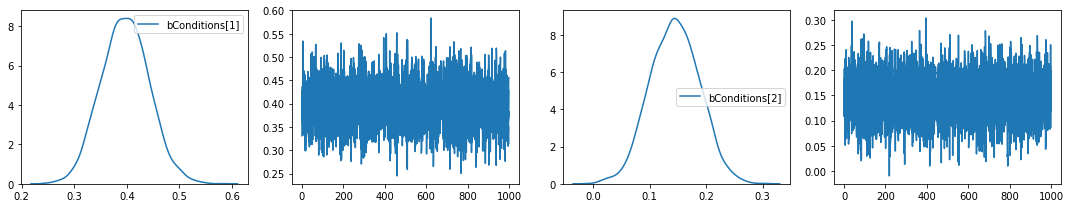

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


fit_df= fit_fe.to_dataframe()
chain_idx = fit_df['draw']
beta11 = fit_df['bConditions[{}]'.format(1)]
beta12 = fit_df['bConditions[{}]'.format(2)]

plt.subplots(figsize=(15,3))
plt.subplot(1,4,1)
sns.kdeplot(beta11)
plt.subplot(1,4,2)
plt.plot(chain_idx, beta11)

plt.subplot(1,4,3)
sns.kdeplot(beta12)
plt.subplot(1,4,4)
plt.plot(chain_idx, beta12)

plt.tight_layout()
plt.show()


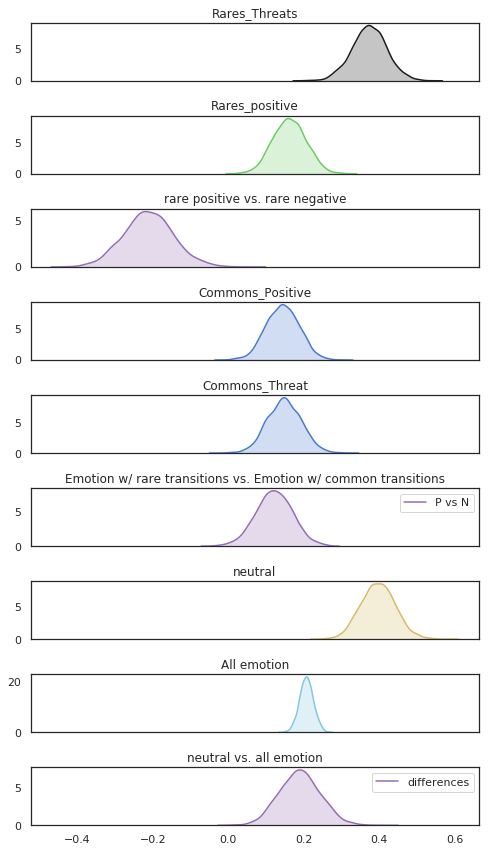

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df_2 = fit_fe.to_dataframe()
#fit_df_2.to_csv('Bayesian_r2_RandomEffects.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['bConditions[{}]'.format(1)]
common_p = fit_df_2['bConditions[{}]'.format(2)]
common_t = fit_df_2['bConditions[{}]'.format(3)]
rare_p = fit_df_2['bConditions[{}]'.format(4)]
rare_t = fit_df_2['bConditions[{}]'.format(5)]

#Compute Contrasts
diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
all_emotion=((rare_p+rare_t+common_p+common_t)/4.0)
diff_type=rares-commons
diff_rare=neutral-rares
diff_common=neutral-commons
diff_emotion=neutral-all_emotion

#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_rp, r_rp = highest_density_interval(rare_p)
l_rt,r_rt=highest_density_interval(rare_t)
l_n,r_n=highest_density_interval(neutral)

rope_val=0.002


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(9, 1, figsize=(7, 12),sharex=True)
# for ax in range(len(axs)):
#     if ax<6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.5,'0',rotation=0)
#         axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-2.5,-1,'Chance',rotation=0)
#     elif ax==6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

axd=sns.distplot(diff_v, hist=False,kde_kws={"shade": True},color="m", ax=axs[2])
axd.set(title='rare positive vs. rare negative',xlabel='')

# axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[2].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
ax2.set(title='Commons_Positive',xlabel='')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Commons_Threat',xlabel='')

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='P vs N')
axv.set(title='Emotion w/ rare transitions vs. Emotion w/ common transitions',xlabel='')

# axs[4].plot([lt, rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-.002, .002],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[6])
axn.set(title='neutral',xlabel='')

axe=sns.distplot(all_emotion, hist=False,kde_kws={"shade": True},color="c", ax=axs[7])
axe.set(title='All emotion',xlabel='')

# axs[7].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[7].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="m", ax=axs[8],label='differences')
ax3.set(title='neutral vs. all emotion',xlabel='')

# axs[8].plot([le, re],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[8].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="b", ax=axs[8],label='diff_emotion')
# ax3.set(title='neutral vs. all emotion',xlabel='')

# axs[9].plot([lp, rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[9].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax4=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[9],label='differences')
# ax4.set(title='neutral vs. positive paired with common transitions',xlabel='')


plt.tight_layout()
plt.show()


## Hypothesis testing via Region of Practical Equivalence (ROPE)

The rope defines a range of potential values that insignificantly differ from a "null hypothesis". These are created for the purposes of making decisions based on the posterior distributions generated by bayesian model fitting. 

Here we define the ROPE via a heuristic used by Kruschke and others, in which we take a the SD of a given effect, multiply it by 0.1 (half of a small effect-size according to Cohen's D definition of effect-size), and add that to null value on either side. Here, the SD we use is that of the posterior distribution of the Grand Mean, which should be thought of as the propensity in the population to learn the latent transition matrix marginalized over subjects differences and types of distraction manipulated in this study. The SD here is 0.02, yielding a ROPE of 0 +/- 0.002. 

### Effect of valence within emotional distractors
The HDI of the posterior distribution over the difference between the negative and positive stimuli being paired with the common transitions is much larger than the ROPE. Kruschke (2018; see https://journals.sagepub.com/doi/pdf/10.1177/2515245918771304) would call this "Undecided" given that many plausible parameter values occur outside the ROPE.

### Effect of emotional vs. neutral distractors
Very clearly, the HDI for the difference between emotional and neutral distractors falls outside the ROPE. In this case, we can decisively reject the null hypothesis defined by the ROPE.

# Random Effects Model

In [6]:
from pystan import StanModel


model_input='''
data {
    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  
  //Conditions
  vector[NxSubjects] aW1;
  vector[NxSubjects] aW2;
  vector[NxSubjects] aW3;
  vector[NxSubjects] aW4;
  vector[NxSubjects] aW5;
  vector[NxSubjects] aW6;
  vector[NxSubjects] aW7;
  vector[NxSubjects] aW8;
  vector[NxSubjects] aW9;
  
  //Group level Prior variance
  real<lower=0.01> sigma_neutral;
  real<lower=0.01> sigma_cp;
  real<lower=0.01> sigma_ct;
  real<lower=0.01> sigma_rp;
  real<lower=0.01> sigma_rt;
  real<lower=0.01> sigma_hrt;
  real<lower=0.01> sigma_qrt;
  real<lower=0.01> sigma_qn;
  real<lower=0.01> sigma_fif;
  
  //Group level mus
  real mu_neutral;
  real mu_cp;
  real mu_ct;
  real mu_rp;
  real mu_rt;
  real mu_hrt;
  real mu_qrt;
  real mu_qn;
  real mu_fif;
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_ct;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;
vector[NxSubjects] theta_hrt;
vector[NxSubjects] theta_qrt;
vector[NxSubjects] theta_qn;
vector[NxSubjects] theta_fif;


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(aW1[k]);
        theta_cp[k] = inv_logit(aW1[k]+aW2[k]);
        theta_ct[k] = inv_logit(aW1[k]+aW3[k]);
        theta_rp[k] = inv_logit(aW1[k]+aW4[k]);
        theta_rt[k] = inv_logit(aW1[k]+aW5[k]);
        theta_hrt[k] = inv_logit(aW1[k]+aW6[k]);
        theta_qrt[k] = inv_logit(aW1[k]+aW7[k]);
        theta_qn[k] = inv_logit(aW1[k]+aW8[k]);
        theta_fif[k] = inv_logit(aW1[k]+aW9[k]);
    }
    
}
model {
    
    mu_neutral ~ normal(0,5);
    sigma_neutral ~ uniform(0,15);
    mu_cp ~ normal(0,5);
    sigma_cp ~ uniform(0,15);
    mu_ct ~ normal(0,5);
    sigma_ct ~ uniform(0,15);
    mu_rp ~ normal(0,5);
    sigma_rp ~ uniform(0,15);
    mu_rt ~normal(0,5);
    sigma_rt ~ uniform(0,15);
    mu_hrt ~normal(0,5);
    sigma_hrt ~ uniform(0,15);
    mu_qrt ~normal(0,5);
    sigma_qrt ~ uniform(0,15);
    mu_qn ~normal(0,5);
    sigma_qn ~ uniform(0,15);
    mu_fif ~normal(0,5);
    sigma_fif ~ uniform(0,15);
    
    aW1~ normal(mu_neutral,sigma_neutral);
    aW2 ~ normal(mu_cp,sigma_cp);
    aW3 ~ normal(mu_ct,sigma_ct);
    aW4 ~ normal(mu_rp,sigma_rp);
    aW5 ~ normal(mu_rt,sigma_rt);
    aW6 ~ normal(mu_hrt,sigma_hrt);
    aW7 ~ normal(mu_qrt,sigma_qrt);
    aW8 ~ normal(mu_qn,sigma_qn);
    aW9 ~ normal(mu_fif,sigma_fif);
        
    for (k in 1:NxSubjects){
            
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
            
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);
            
            // Threat-rare HALF choices
            Choice[k,6,:] ~ bernoulli(theta_hrt[k]);
            
            // Threat-rare QRTR choices
            Choice[k,7,:] ~ bernoulli(theta_qrt[k]);
            
            // Neutral QRTR choices
            Choice[k,8,:] ~ bernoulli(theta_qn[k]);
            
            // 50-50 choices
            Choice[k,9,:] ~ bernoulli(theta_fif[k]);
            
              
      }
    }
    
'''

data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data,#choice datas
              'NxConditions':9,
              'NxSubjects':136
                    }

control={'adapt_delta':0.9,
         'max_treedepth':18}
model_fit = StanModel(model_code=model_input)
RE_fit = model_fit.sampling(data=data_input,iter=2000)
print(RE_fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee510f90470c76176fbc827c8b48937e NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_ee510f90470c76176fbc827c8b48937e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
aW1[1]               6.72    0.03   1.72   3.57   5.47   6.66   7.83  10.23   2558    1.0
aW1[2]               1.84    0.01   0.63   0.76   1.39   1.79   2.24   3.23   1789    1.0
aW1[3]               2.96    0.02   0.85   1.48   2.37   2.89   3.48   4.82   1802    1.0
aW1[4]               5.64    0.03   1.64   2.87   4.43   5.53   6.67   9.16   2902    1.0
aW1[5]               6.64    0.04   1.76   3.55    5.4    6.5   7.78  10.41   2407    1.0
aW1[6]               6.53    0.04   1.73   3.49    5.3   6.43   7.69  10.12   1956    1.0
aW1[7]               5.77    0.03   1.55   3.05   4.66   5.66   6.75   9.13   2020    1.0
aW1[8]               5.36    0.03   1.52   2.69   4.25   5.26   6.34   8.58   2019    1.0
a

# Reduced Parameters

In [6]:
from pystan import StanModel


model_input='''
data {
    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  
  //Conditions
  vector[NxSubjects] b0;
  vector[NxSubjects] aW1;
  vector[NxSubjects] aW2;
  vector[NxSubjects] aW3;
  vector[NxSubjects] aW4;
  vector[NxSubjects] aW5;

  
  //Group level Prior variance
  vector[5] sigma;

  
  //Group level mus
  vector[5] mu;

    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_ct;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;



for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(b0[k]+aW1[k]);
        theta_cp[k] = inv_logit(b0[k]+aW2[k]);
        theta_ct[k] = inv_logit(b0[k]+aW3[k]);
        theta_rp[k] = inv_logit(b0[k]+aW4[k]);
        theta_rt[k] = inv_logit(b0[k]+aW5[k]);
     
    }
    
}
model {
    
    b0 ~ normal(0,10);
    mu ~ normal(0,10);
    sigma ~ normal(0,10);
    
    aW1 ~ normal(mu[1],sigma[1]);
    aW2 ~ normal(mu[2],sigma[2]);
    aW3 ~ normal(mu[3],sigma[3]);
    aW4 ~ normal(mu[4],sigma[4]);
    aW5 ~ normal(mu[5],sigma[5]);
   
        
    for (k in 1:NxSubjects){
            
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
            
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);
            
              
      }
    }
    
'''

data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data,#choice datas
              'NxConditions':9,
              'NxSubjects':136
                    }

control={'adapt_delta':0.9,
         'max_treedepth':18}
model_fit = StanModel(model_code=model_input)
RE_fitr = model_fit.sampling(data=data_input,iter=2000)
print(RE_fitr)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c888550124159a7fcf28e8e4795777da NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_c888550124159a7fcf28e8e4795777da.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0[1]                5.28    0.06   3.39  -0.96   2.91    5.1   7.41  12.47   3104    1.0
b0[2]               -2.58    0.05   2.57  -7.61  -4.35  -2.57  -0.84    2.4   3179    1.0
b0[3]                1.76    0.05   2.76  -3.54  -0.12    1.7   3.59    7.3   3202    1.0
b0[4]               11.08     0.1   5.74   1.66   6.92  10.45  14.44  24.54   3212    1.0
b0[5]                4.58    0.06   3.25  -1.29   2.38   4.44   6.57  11.36   3185    1.0
b0[6]               11.25     0.1   5.96   1.64    7.0  10.51  14.76  24.72   3375    1.0
b0[7]               10.99     0.1   5.76   1.78   6.76  10.33  14.49   23.7   3107    1.0
b0[8]                5.15    0.06   3.46   -1.1   2.75   5.01   7.29  12.53   3478    1.0
b

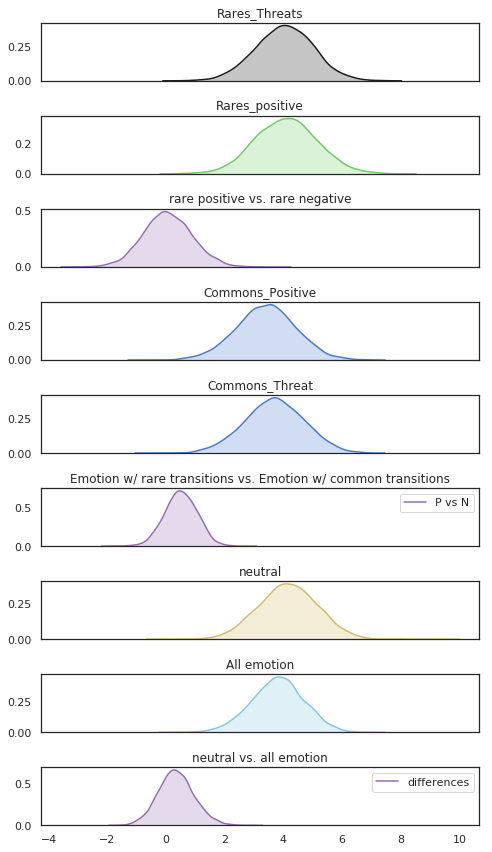

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df_2 = RE_fitr.to_dataframe()
#fit_df_2.to_csv('Bayesian_r2_RandomEffects.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['mu[1]']
common_p = fit_df_2['mu[2]']
common_t = fit_df_2['mu[3]']
rare_p = fit_df_2['mu[4]']
rare_t = fit_df_2['mu[5]']

#Compute Contrasts
diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
all_emotion=((rare_p+rare_t+common_p+common_t)/4.0)
diff_type=rares-commons
diff_rare=neutral-rares
diff_common=neutral-commons
diff_emotion=neutral-all_emotion

#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_rp, r_rp = highest_density_interval(rare_p)
l_rt,r_rt=highest_density_interval(rare_t)
l_n,r_n=highest_density_interval(neutral)

rope_val=0.315


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(9, 1, figsize=(7, 12),sharex=True)
# for ax in range(len(axs)):
#     if ax<6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.5,'0',rotation=0)
#         axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-2.5,-1,'Chance',rotation=0)
#     elif ax==6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

axd=sns.distplot(diff_v, hist=False,kde_kws={"shade": True},color="m", ax=axs[2])
axd.set(title='rare positive vs. rare negative',xlabel='')

# axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[2].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
ax2.set(title='Commons_Positive',xlabel='')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Commons_Threat',xlabel='')

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='P vs N')
axv.set(title='Emotion w/ rare transitions vs. Emotion w/ common transitions',xlabel='')

# axs[4].plot([lt, rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-.002, .002],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[6])
axn.set(title='neutral',xlabel='')

axe=sns.distplot(all_emotion, hist=False,kde_kws={"shade": True},color="c", ax=axs[7])
axe.set(title='All emotion',xlabel='')

# axs[7].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[7].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="m", ax=axs[8],label='differences')
ax3.set(title='neutral vs. all emotion',xlabel='')

# axs[8].plot([le, re],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[8].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="b", ax=axs[8],label='diff_emotion')
# ax3.set(title='neutral vs. all emotion',xlabel='')

# axs[9].plot([lp, rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[9].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

# ax4=sns.distplot(diff_common, hist=False, kde_kws={"shade": True},color="g", ax=axs[9],label='differences')
# ax4.set(title='neutral vs. positive paired with common transitions',xlabel='')


plt.tight_layout()
plt.show()


In [9]:
from pystan import StanModel


model_input='''
data {
    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  
  //Conditions
  vector[NxSubjects] aW1_raw;
  vector[NxSubjects] aW2_raw;
  vector[NxSubjects] aW3_raw;
  vector[NxSubjects] aW4_raw;
  vector[NxSubjects] aW5_raw;
  vector[NxSubjects] aW6_raw;
  vector[NxSubjects] aW7_raw;
  vector[NxSubjects] aW8_raw;
  vector[NxSubjects] aW9_raw;
  
  //Group level Prior variance
  real<lower=0.01> sigma_neutral;
  real<lower=0.01> sigma_cp;
  real<lower=0.01> sigma_ct;
  real<lower=0.01> sigma_rp;
  real<lower=0.01> sigma_rt;
  real<lower=0.01> sigma_hrt;
  real<lower=0.01> sigma_qrt;
  real<lower=0.01> sigma_qn;
  real<lower=0.01> sigma_fif;
  
  //Group level mus
  real mu_neutral;
  real mu_cp;
  real mu_ct;
  real mu_rp;
  real mu_rt;
  real mu_hrt;
  real mu_qrt;
  real mu_qn;
  real mu_fif;
    
}

transformed parameters {

vector[NxSubjects] aW1;
vector[NxSubjects] aW2;
vector[NxSubjects] aW3;
vector[NxSubjects] aW4;
vector[NxSubjects] aW5;
vector[NxSubjects] aW6;
vector[NxSubjects] aW7;
vector[NxSubjects] aW8;
vector[NxSubjects] aW9;

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_ct;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;
vector[NxSubjects] theta_hrt;
vector[NxSubjects] theta_qrt;
vector[NxSubjects] theta_qn;
vector[NxSubjects] theta_fif;

//Non-centered parameterization
  aW1 = mu_neutral + sigma_neutral * aW1_raw;
  aW2 = mu_cp + sigma_cp * aW2_raw;
  aW3 = mu_ct + sigma_ct * aW3_raw;
  aW4 = mu_rp + sigma_rp * aW4_raw;
  aW5 = mu_rt + sigma_rt * aW5_raw;
  aW6 = mu_hrt + sigma_hrt * aW6_raw;
  aW7 = mu_qrt + sigma_qrt * aW7_raw;
  aW8 = mu_qn + sigma_qn * aW8_raw;
  aW9 = mu_fif + sigma_fif * aW9_raw;


for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(aW1[k]);
        theta_cp[k] = inv_logit(aW1[k]+aW2[k]);
        theta_ct[k] = inv_logit(aW1[k]+aW3[k]);
        theta_rp[k] = inv_logit(aW1[k]+aW4[k]);
        theta_rt[k] = inv_logit(aW1[k]+aW5[k]);
        theta_hrt[k] = inv_logit(aW1[k]+aW6[k]);
        theta_qrt[k] = inv_logit(aW1[k]+aW7[k]);
        theta_qn[k] = inv_logit(aW1[k]+aW8[k]);
        theta_fif[k] = inv_logit(aW1[k]+aW9[k]);
    }
    
}
model {
    
    mu_neutral ~ normal(0,10);
    sigma_neutral ~ uniform(0.01,10);
    mu_cp ~ normal(0,10);
    sigma_cp ~ uniform(0.01,10);
    mu_rp ~ normal(0,10);
    sigma_rp ~ uniform(0.01,10);
    mu_rt ~normal(0,10);
    sigma_rt ~ uniform(0.01,10);
    mu_ct ~normal(0,10);
    sigma_ct ~ uniform(0.01,10);
    mu_hrt ~normal(0,10);
    sigma_hrt ~ uniform(0.01,10);
    mu_qrt ~normal(0,10);
    sigma_qrt ~ uniform(0.01,10);
    mu_qn ~normal(0,10);
    sigma_qn ~ uniform(0.01,10);
    mu_fif ~normal(0,10);
    sigma_fif ~ uniform(0.01,10);
    
    aW1 ~ std_normal();
    aW2 ~ std_normal();
    aW3 ~ std_normal();
    aW4 ~ std_normal();
    aW5 ~ std_normal();
    aW6 ~ std_normal();
    aW7 ~ std_normal();
    aW8 ~ std_normal();
    aW9 ~ std_normal();
        
    for (k in 1:NxSubjects){
            
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
            
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);
            
            // Threat-rare HALF choices
            Choice[k,6,:] ~ bernoulli(theta_hrt[k]);
            
            // Threat-rare QRTR choices
            Choice[k,7,:] ~ bernoulli(theta_qrt[k]);
            
            // Neutral QRTR choices
            Choice[k,8,:] ~ bernoulli(theta_qn[k]);
            
            // 50-50 choices
            Choice[k,9,:] ~ bernoulli(theta_fif[k]);
            
              
      }
    }
    
'''
data_input = {
              'Ntrials': 20, # trials per condition
              'Choice':choice_data,#choice datas
              'NxConditions':9,
              'NxSubjects':136
                    }

model_fit = StanModel(model_code=model_input)
RE_fit_NC = model_fit.sampling(data=data_input,iter=2000)
print(RE_fit_NC)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5133a17081ab382da34b02b8366dfa01 NOW.
Process ForkPoolWorker-48:
Process ForkPoolWorker-47:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in ge

KeyboardInterrupt: 

  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


## Disentangling IT from LR on performance by varying number of trials for learning

$S$ = States

$A$ = Actions

$\eta$ = Learning rate for state transitions

$O$ = Observed state 

$V$ = $P(S_{next}|A_{i},S_{current})$

$V_{i+1}=V_{i} + \eta \cdot (O-V_{i})$

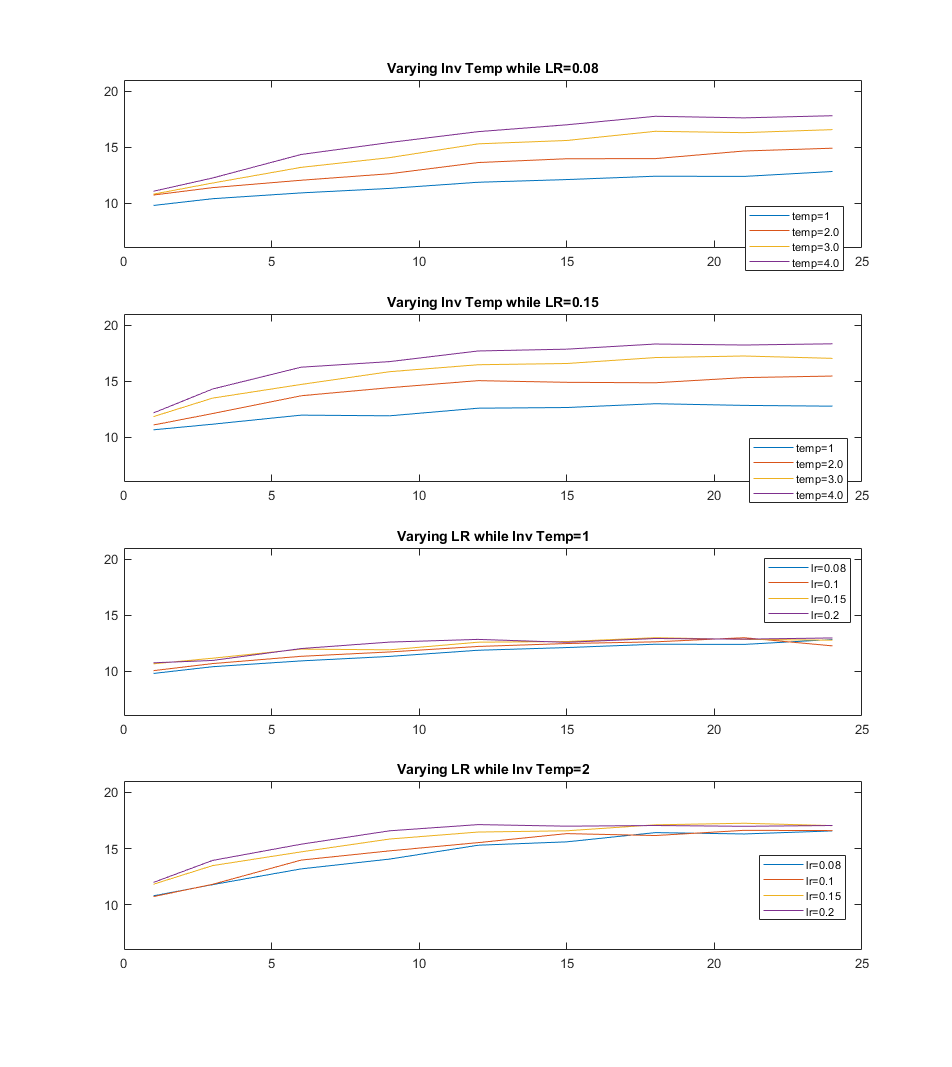

In [2]:
from IPython.display import Image
Image(filename='lr_v_it.png')